# Verification of Paper Examples

The purpose of this notebook is to be a pared-down version of ``derivation_of_expectation_of_power``, in which we produce only the plots necessary to verify each formula (we also list the formula in each section for clarity). Only sections represented in the paper are here.

## Imports and Definitions

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os

from powerbox.dft import fft
from powerbox.tools import angular_average, angular_average_nd

from numpy.fft import fftfreq, fft2, fftshift

from scipy.integrate import simps

# For testing against basic simulations
from spore.fortran_routines.resample import grid_visibilities
# from spore.mock.foregrounds import GalacticForegrounds
# from spore.model.spatial_dist import PureClustering_FlatSky
# from spore.model.spectral_index import UniversalDist
# from spore.model.beam import CircularGaussian
# from spore.model.foregrounds import _cov_fourier

/home/steven/Documents/Projects/powerbox/powerbox/dft.py:53: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


### Standard Definitions

In [2]:
# Find a reasonable range of eta
def get_eta_log(n):
    eta_base_large = fftfreq(1024, d=2./1024.) # Lots of fine channels
    eta_base_small = fftfreq(10, d=10./10.) # Few broad channels
    eta_base_large = eta_base_large[eta_base_large>0]
    eta_base_small = eta_base_small[eta_base_small>0]

    eta = np.logspace(np.log10(np.abs(eta_base_small).min()),np.log10(np.abs(eta_base_large).max()), n)
    return eta

# Scales
eta_log = get_eta_log(100)
u_log = np.logspace(0, 3, 120)
f = np.linspace(1,1.6/1.5,100)

# Physical Parameters
mu1 = 1      # Mean brightness
S0  = 1      # Single-source brightness
mu2 = 1      # Second-moment of source counts
nu0 = 150.   # Reference Frequency (MHz)
sigma = 0.2  # Beam width (at ref. freq.)
tau = np.sqrt(1./(2 * (10./nu0/2)**2))  # Approximately the half-width of a 10MHz window
fmid = 1.    # Middle of the bandpass (1=reference freq.)

# Filepaths
figdir = os.path.expanduser("~/Documents/Projects/Foregrounds/expected_power_paper/13107486cbcxtfxpzsxp/figures")

### Plotting/Utility Functions

In [3]:
def power_from_vis(vis_nu, f, nu0):
    "Get the power from a set of visibilities at vector u."
    res, eta = fft(nu0 * vis_nu, L = f[-1]- f[0], axes=(0,))
    eta = eta[0]

    res = np.abs(res)**2
    res = res[len(f)/2+1:]
    eta = eta[len(f)/2+1:]
    return res, eta/nu0

def power_from_visgrid(vis, f, ugrid, vgrid, nu0, weights = 1, bins=50):
    """
    Get the power from a set of gridded visibilities (as a function of nu)
    
    Parameters
    ----------
    vis : (Ngrid_u, Ngrid_v, f)-shaped array
        The visibilities
        
    f : (f)-shaped array
        The normalised frequencies
        
    ugrid, vgrid : vectors
        The vectors defining the co-ordinates of the visibility grid (1D each)
        
    nu0 : float
        Reference frequency.
        
    Notes
    -----
    Only the first frequency bin of weights are used. Not really sure what to do here.
    """
    # First do FT
    res, eta = fft(nu0 * vis, L = f[-1]- f[0], axes=(-1,))
    eta = eta[0]

    res = res[:,:,len(f)/2+1:]
    eta = eta[len(f)/2+1:]
    
    print(res.shape)
    res, binav,_, linear_bins = angular_average_nd(res, [ugrid, vgrid, f], n=2, bins=bins, weights=weights[:,:,0].T)
    
    res = np.abs(res)**2
    return res, eta/nu0, binav, linear_bins


def plot_power(power, u, eta, vmin=None, u_is_logscale=True, eta_is_logscale=True):
    if u_is_logscale:
        umin = np.log10(u[0])
        umax = np.log10(u[-1])
    else:
        umin = u[0]
        umax = u[-1]
        
    if eta_is_logscale:
        etamin = np.log10(eta[0])
        etamax = np.log10(eta[-1])
    else:
        etamin = eta[0]
        etamax = eta[-1]
        
    plt.imshow(power,origin='lower', norm=LogNorm(), extent = (umin,umax,etamin,etamax), 
               vmin=vmin, aspect='auto')
    plt.xlabel(r"$\log_{10} u$", fontsize=13)
    plt.ylabel(r"$\log_{10} \eta$", fontsize=13)
    
    if not u_is_logscale:
        plt.xscale('log')
    if not eta_is_logscale:
        plt.yscale('log')
        
    plt.colorbar()

## Single Source

### NGP

#### Static

Our final form for this is

\begin{equation}
P(\eta, u) = \frac{S_0^2 \nu_0^2 \pi}{\tau^2} \exp\left(-\frac{l_0^2}{\sigma^2}\right) \frac{1}{\pi}\int_0^\pi d\theta \ \exp\left( -\frac{2\pi^2}{\tau^2} (\nu_0 \eta + ul_0\cos\theta)^2\right)
\end{equation}

In [4]:
def power_ss_ngp_static(u_log=u_log, eta_log=eta_log, nu0=nu0, l0=0, sigma=sigma, tau=tau, S0=S0):

    theta = np.linspace(0, np.pi, 1000)
    THETA, ETA, U = np.meshgrid(theta, eta_log, u_log, indexing='ij')

    integ = np.exp(-2*np.pi**2 *(nu0*ETA + U*l0*np.cos(THETA))**2/tau**2)
    prefac = S0**2 * nu0**2 *np.exp(-l0**2/sigma**2)/tau**2
    print(prefac)
#     print(integ.shape)
    return prefac * simps(integ.T, theta)

38.9400391536


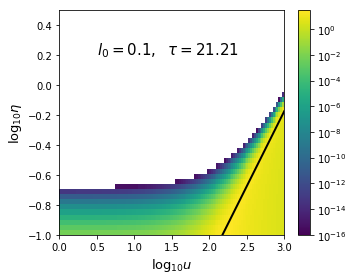

In [42]:
l0 = 0.1
plt.figure(figsize=(5,4))
plot_power(power_ss_ngp_static(l0=l0).T,u_log, eta_log, vmin = 1e-16)

# Add some lines for theoretical calculations
ax = plt.gca()
plt.axhline(np.log10(np.sqrt(1./(2*np.pi**2*nu0**2/tau**2))))
plt.plot(np.log10(u_log), np.log10(u_log) + np.log10(l0/nu0), color='k', lw=2)

plt.text(0.5, 0.2, r"$l_0 = 0.1,\ \  \tau = %2.2f$"%tau, fontsize=15)
plt.ylim(-1,0.5)
plt.tight_layout()

if figdir:
    plt.savefig(os.path.join(figdir, "power_ss_ngp_static0.pdf"))

0.0965227068114


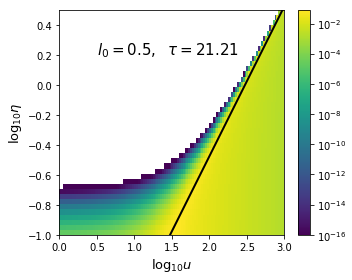

In [43]:
l0 = 0.5
plt.figure(figsize=(5,4))
plot_power(power_ss_ngp_static(l0=l0).T,u_log, eta_log, vmin = 1e-16)

# Add some lines for theoretical calculations
ax = plt.gca()
plt.axhline(np.log10(np.sqrt(1./(2*np.pi**2*nu0**2/tau**2))))
plt.plot(np.log10(u_log), np.log10(u_log) + np.log10(l0/nu0), color='k', lw=2)

plt.text(0.5, 0.2, r"$l_0 = 0.5,\ \  \tau = %2.2f$"%tau, fontsize=15)
plt.ylim(-1,0.5)
plt.tight_layout()

if figdir:
    plt.savefig(os.path.join(figdir, "power_ss_ngp_static1.pdf"))

4.8675048942


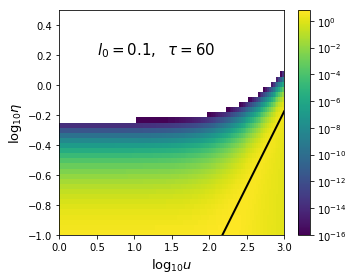

In [44]:
l0 = 0.1
thistau = 60.0
plt.figure(figsize=(5,4))
plot_power(power_ss_ngp_static(l0=l0, tau=thistau).T,u_log, eta_log, vmin = 1e-16)

# Add some lines for theoretical calculations
ax = plt.gca()
plt.axhline(np.log10(np.sqrt(1./(2*np.pi**2*nu0**2/thistau**2))))
plt.plot(np.log10(u_log), np.log10(u_log) + np.log10(l0/nu0), color='k', lw=2)
plt.text(0.5, 0.2, r"$l_0 = 0.1,\ \  \tau = 60$", fontsize=15)
plt.ylim(-1,0.5)

plt.tight_layout()

if figdir:
    plt.savefig(os.path.join(figdir, "power_ss_ngp_static2.pdf"))

#### Chromatic

Our final form for this is

\begin{equation}
	P(\eta, u) =  \frac{S_0^2 \nu_0^2 \pi}{\pi \left(\tau^2+\frac{l_0^2}{2\sigma^2}\right)} \exp\left[-\tau^2 f_:^2 \left(1 - \frac{\tau^2}{\tau^2 + l_0^2/2\sigma^2}\right)\right] \int_0^{\pi} d\theta\  \exp\left( -\frac{2\pi^2}{\tau^2 + l_0^2/2\sigma^2} (\nu_0 \eta + ul_0\cos\theta)^2\right).
\end{equation}

In [74]:
def power_ss_ngp_chromatic(u_log=u_log, eta_log=eta_log, nu0=nu0, l0=0, sigma=sigma, tau=tau, S0=S0, fmid=fmid):

    theta = np.linspace(0, np.pi, 1000)
    THETA, ETA, U = np.meshgrid(theta, eta_log, u_log, indexing='ij')

    p = tau**2 + l0**2/(2*sigma**2)
    integ = np.exp(-2*np.pi**2 *(nu0*ETA + U*l0*np.cos(THETA))**2/p)
    prefac = S0**2 * nu0**2 *np.exp(-tau**2*fmid**2*(1 - tau**2/p))/p
    
    return prefac * simps(integ.T, theta)

(-1, 1)

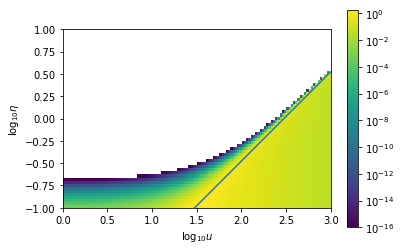

In [78]:
l0 = 0.5
this_sigma = 1*sigma
plot_power(power_ss_ngp_chromatic(l0=l0, sigma=this_sigma).T,u_log, eta_log, vmin = 1e-16)

# Add some lines for theoretical calculations
ax = plt.gca()
p = tau**2 + l0**2/(2*sigma**2)
plt.axhline(np.log10(np.sqrt(1./(2*np.pi**2*nu0**2/p))))
plt.plot(np.log10(u_log), np.log10(u_log) + np.log10(l0/nu0))

plt.ylim(-1,1)

### Weighted Gridding

#### Static

Without writing down the equation, we obtain the answer that the wedge disappears. We want to check if this behaviour is true. 

In [4]:
sigma_u = 30.0

In [47]:
def get_baselines(n=1000, sigma_u = sigma_u):
    u = np.random.normal(scale=sigma_u, size=n)
    theta = np.random.uniform(low=0,high=2*np.pi, size=n)
    x = u*np.cos(theta)
    y = u* np.sin(theta)
    return x,y

def beam(l0,sigma, f = 1):
    return np.exp(-l0**2*f**2/(2*sigma**2))

def get_visibilities(u,v,S0=S0, l0=0, sigma=sigma, f = 1, chromatic_beam=False):
    F, U = np.meshgrid(f,u, indexing='ij')
    if chromatic_beam:
        tmp = F
    else:
        tmp = 1

    return S0 * beam(l0, sigma, tmp) * np.exp(-2j*np.pi*F*l0*U) #don't need the v, because we just assume l0 is at v=0.

def grid_visibilities_weighted(vis, u, v,f, sigma=sigma, ngrid=100):
    """
    vis should be a (f,bl) shaped array.
    """
    U = np.sqrt(u**2 + v**2)
    gridu = np.linspace(0, U.max()*0.75, ngrid)
    gridv = np.linspace(-U.max()*0.75, U.max()*.75, 2*ngrid)
    
    GRIDU, GRIDV = np.meshgrid(gridu, gridv, indexing='ij')
    
    gridded_vis, weights = grid_visibilities(f = f, visibilities = vis.T, baselines = np.array([np.abs(u),v]).T,
                                             ugrid = GRIDU, vgrid = GRIDV, radmin = 5, static_beam = True,
                                             sigma0 = sigma, nthreads=8)
    return gridu, gridv, gridded_vis, weights

In [49]:
np.random.seed(1234)
u,v = get_baselines(30000)
ff = np.linspace(1.,158./150., 256)
visibilities = get_visibilities(u,v, f=ff, l0=0.5)
grid_u, grid_v, gridded_vis, weights = grid_visibilities_weighted(visibilities, u, v, f=ff)

(-90, 90)

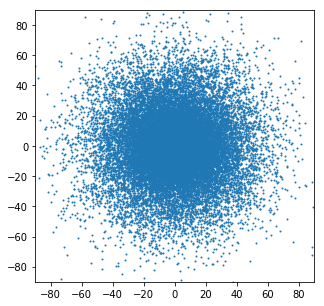

In [50]:
plt.figure(figsize=(5,5))
plt.scatter(u,v, s=1)
plt.xlim(-90,90)
plt.ylim(-90,90)

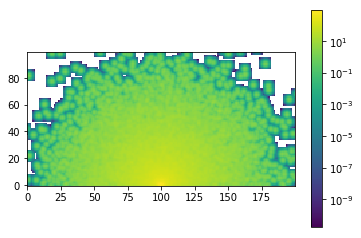

In [57]:
plt.imshow(weights[:,:,0], origin='lower', norm=LogNorm())
plt.colorbar()

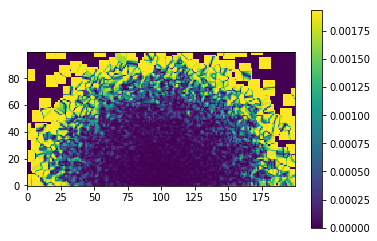

In [55]:
vis2 = np.abs(gridded_vis)**2
plt.imshow(vis2[:,:,0], origin='lower')
plt.colorbar()

In [58]:
u.shape

(30000,)

In [89]:
beam_at_0 = np.exp(-2*np.pi**2*0.6**2 * ((u)**2+v**2))

In [90]:
nonzero = beam_at_0 > 0
nonzero_beam = beam_at_0[nonzero]

In [91]:
beam_at_0.max(), np.sum(beam_at_0),beam_at_0.min(), len(beam_at_0[beam_at_0>0])

(0.99999925597048733, 272.16602660106372, 0.0, 8046)

In [92]:
np.max(np.abs(visibilities)**2)

0.0019304541362277113

In [93]:
np.sum(beam_at_0 * visibilities[0])

(10.095307241318638-0.018607492906622891j)

In [94]:
np.abs(np.sum(beam_at_0 * visibilities[0])/np.sum(beam_at_0))**2

0.0013758552047984623

In [51]:
gridded_vis[np.isnan(gridded_vis)] = 0.0
power, eta, _, ubins = power_from_visgrid(gridded_vis, f, grid_u, grid_v, nu0, weights = weights, bins=50)

(100, 200, 205)


In [52]:
power

array([[  7.73344790e-08,   2.14741787e-07,   2.09283196e-09, ...,
          2.17553883e-07,   1.73655091e-08,   9.55991127e-08],
       [  1.72593372e-08,   9.44110109e-08,   1.73634111e-07, ...,
          3.48449622e-08,   4.36605528e-08,   4.28920948e-08],
       [  1.74018264e-07,   2.81473699e-07,   2.66123995e-07, ...,
          1.70007266e-07,   1.76547329e-07,   1.47807290e-07],
       ..., 
       [             nan,              nan,              nan, ...,
                     nan,              nan,              nan],
       [             nan,              nan,              nan, ...,
                     nan,              nan,              nan],
       [             nan,              nan,              nan, ...,
                     nan,              nan,              nan]])

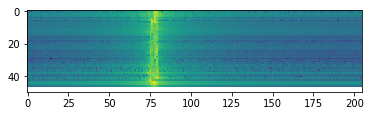

In [54]:
plt.imshow(power, norm=LogNorm())


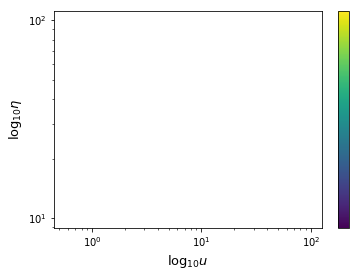

In [53]:
plot_power(power.T, ubins, eta, u_is_logscale=False, eta_is_logscale=False)

In [41]:
weights.shape

(100, 200, 100)

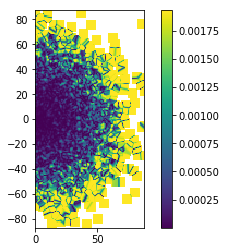

In [31]:
plt.imshow(power[:,:,0].T, origin='lower', extent=(grid_u.min(), grid_u.max(), grid_v.min(), grid_v.max()))
plt.colorbar()

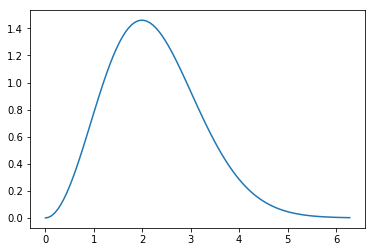

In [95]:
u = np.linspace(0,2*np.pi, 100)
plt.plot(u, u**2*np.exp(-u**2*( 1/(2*sigma_u**2) + 2*np.pi*sigma**2)))